In [1]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
conn = mysql.connector.connect(host = "localhost",
                               username = "root",
                              password = "Jaishreeram",
                              database = "ecommerce" )
cur = conn.cursor()

#  All unique cities where customers are located.

In [3]:
query = """select distinct customer_city from customers """

cur.execute(query)

dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["city"])
df

,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Number of orders placed in 2017.

In [4]:
query = """select count(order_id)
           from orders 
           where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

dt = cur.fetchall()

dt[0][0]

90202

# Total sales per category.

In [5]:
query = """select upper(p.product_category), round(sum(oi.price + oi.freight_value),2) as total_sales
           from order_items as oi 
           join products as p
           on oi.product_id = p.product_id
           group by p.product_category
           order by total_sales desc"""
 
cur.execute(query)

dt = cur.fetchall()

df = pd.DataFrame(dt, columns = ["Product Category" , "Sales"])
df

,Product Category,Sales
0,HEALTH BEAUTY,5764992.28
1,WATCHES PRESENT,5222166.43
2,BED TABLE BATH,4966726.88
3,SPORT LEISURE,4626625.92
4,COMPUTER ACCESSORIES,4237089.59
...,...,...
69,FLOWERS,6395.64
70,HOUSE COMFORT 2,4682.32
71,CDS MUSIC DVDS,3819.96
72,FASHION CHILDREN'S CLOTHING,2661.44


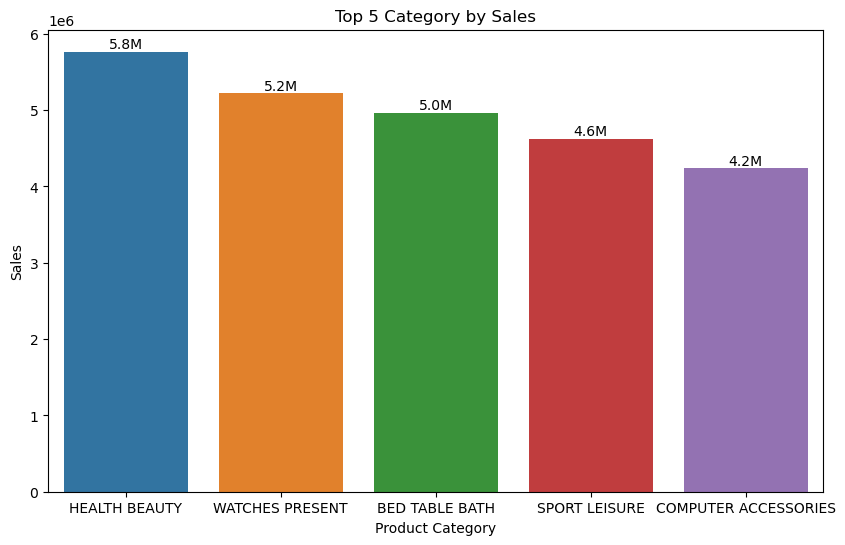

In [6]:
# Visualization of top 5 product category

fd = df.head(5)

plt.figure(figsize = (10,6))
xa = sns.barplot(x = 'Product Category', y = 'Sales', data = fd )
plt.title("Top 5 Category by Sales")

def formated_num(number):
    if number >= 1e6:
        return f'{number / 1e6:.1f}M'
    if number >= 1e3:
        return f'{number / 1e3:.1f}k'
    else :
        return str(number)

for bars in xa.containers:
    xa.bar_label(bars, labels = [formated_num(label) for label in bars.datavalues])
    


# Percentage of orders that were paid in installments. 

In [7]:
query = """select (select count(order_id) from payments where payment_installments >= 1)/ count(order_id) * 100 
           from payments"""
 
cur.execute(query)

dt = cur.fetchall()
dt

[(Decimal('99.9981'),)]

# Count the number of customers from each state

Text(0.5, 1.0, 'Number of customer by State')

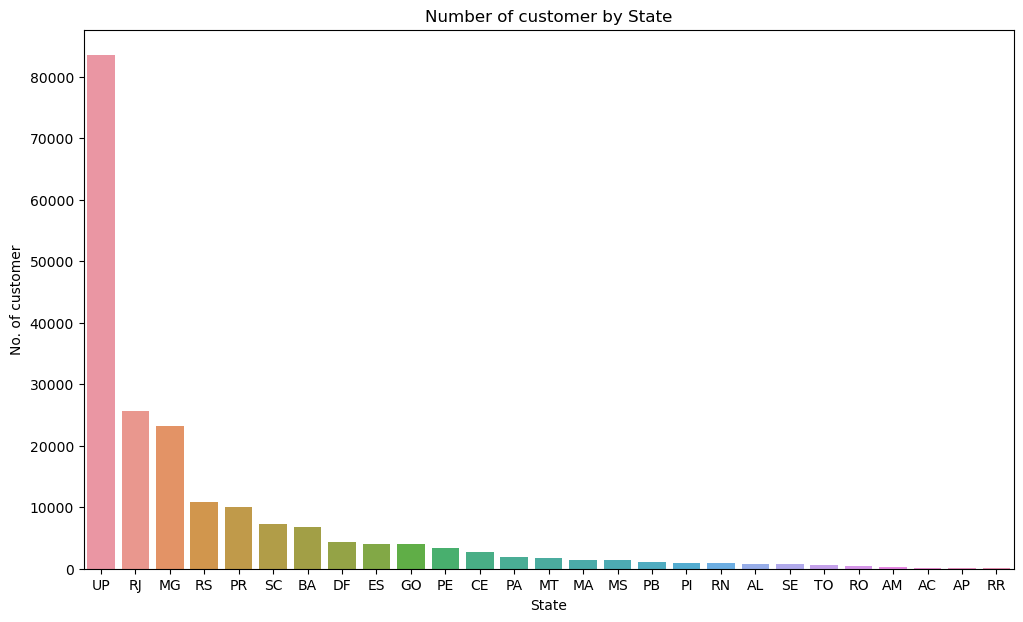

In [8]:
query = """select customer_state, count(customer_id)
from customers 
group by customer_state"""
 
cur.execute(query)

dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["State","No. of customer"])
df = df.sort_values(by = "No. of customer", ascending = False )

plt.figure(figsize = (12,7))
sns.barplot(x = "State", y = "No. of customer", data = df )
plt.title("Number of customer by State")

#  Number of orders per month in 2018.

In [9]:
query = """select monthname(order_purchase_timestamp) as Months , count(order_id) as Number_of_order
from orders where year(order_purchase_timestamp) = 2018
group by Months
order by Months"""
 
cur.execute(query)

dt = cur.fetchall()

df = pd.DataFrame(dt, columns = ["Months","Order_count"])
df

,Months,Order_count
0,April,13878
1,August,13024
2,February,13456
3,January,14538
4,July,12584
5,June,12334
6,March,14422
7,May,13746
8,October,8
9,September,32


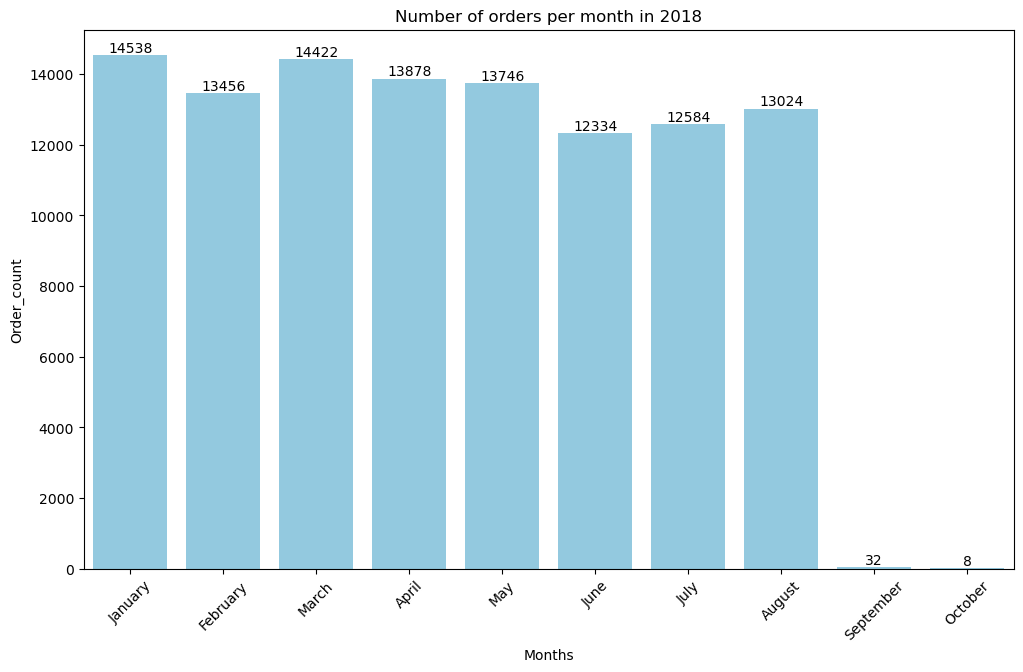

In [10]:
od = ["January", "February", "March",  "April", "May", "June", "July", "August", "September", "October"]

plt.figure(figsize = (12,7))
ax = sns.barplot(x = "Months", y = "Order_count", data = df, order = od, color = "skyblue")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018")
plt.show()

# Average number of products per order, grouped by customer city

In [11]:
query = """SELECT 
    customers.customer_city,
    ROUND(AVG(order_count.oc), 2) AS average_od
FROM
    customers
        JOIN
    (SELECT 
        orders.order_id,
            orders.customer_id,
            COUNT(order_items.order_item_id) AS oc
    FROM
        orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id , orders.customer_id) AS order_count ON customers.customer_id = order_count.customer_id
GROUP BY customers.customer_city
order by average_od desc"""
 
cur.execute(query)

dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["City","Avg_order"])
df

,City,Avg_order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
...,...,...
4105,tuiuti,4.00
4106,aurora do para,4.00
4107,nova america,4.00
4108,tibau do sul,4.00


# Percentage of total revenue contributed by each product category

In [12]:
query = """select p.product_category,
round((sum(oi.price + oi.freight_value) / (select sum(price) + sum(freight_value) from order_items)) *100,2) as percentage_of_total_revenue
from order_items as oi 
join products as p
on oi.product_id = p.product_id
group by p.product_category
order by percentage_of_total_revenue desc"""
 
cur.execute(query)

dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["Category","Percentage_contribution"])
df

,Category,Percentage_contribution
0,HEALTH BEAUTY,18.19
1,Watches present,16.48
2,bed table bath,15.67
3,sport leisure,14.60
4,computer accessories,13.37
...,...,...
69,flowers,0.02
70,Fashion Children's Clothing,0.01
71,House Comfort 2,0.01
72,cds music dvds,0.01


# Correlation between product price and the number of times a product has been purchased.

In [13]:
query = """select pd.product_category, count(od.product_id) as order_count,
round(avg(od.price),2) as avg_price
from products as pd join order_items as od
on pd.product_id = od.product_id
group by pd.product_category"""
 
cur.execute(query)

dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["Category","order_count","avg_price"])

In [14]:
arr1 = df["order_count"]
arr2 = df["avg_price"]

a = np.corrcoef([arr1,arr2])
print("Correlation between product price and the number of times a product has been purchased is :",a)

Correlation between product price and the number of times a product has been purchased is : [[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


# Total revenue generated by each seller, and rank them by revenue.

In [15]:
query = """select *, dense_rank() over(order by revenue_by_seller desc) as Rankk from
(select oi.seller_id , sum(p.payment_value) as revenue_by_seller
from order_items as oi join payments as p
on oi.order_id = p.order_id
group by oi.seller_id) as sp;"""
 
cur.execute(query)

dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["seller_id","Revenue","Rank"])
print(df)
fd = df.head(5)
print(fd)

                             seller_id       Revenue  Rank
0     7c67e1448b00f6e969d365cea6b010ab  2.028668e+06     1
1     1025f0e2d44d7041d6cf58b6550e0bfa  1.232888e+06     2
2     4a3ca9315b744ce9f8e9374361493884  1.204981e+06     3
3     1f50f920176fa81dab994f9023523100  1.161014e+06     4
4     53243585a1d6dc2643021fd1853d8905  1.139612e+06     5
...                                ...           ...   ...
3090  ad14615bdd492b01b0d97922e87cb87f  7.684000e+01  3082
3091  702835e4b785b67a084280efca355756  7.424000e+01  3083
3092  4965a7002cca77301c82d3f91b82e1a9  6.544000e+01  3084
3093  77128dec4bec4878c37ab7d6169d6f26  6.088000e+01  3085
3094  cf6f6bc4df3999b9c6440f124fb2f687  4.888000e+01  3086

[3095 rows x 3 columns]
                          seller_id       Revenue  Rank
0  7c67e1448b00f6e969d365cea6b010ab  2.028668e+06     1
1  1025f0e2d44d7041d6cf58b6550e0bfa  1.232888e+06     2
2  4a3ca9315b744ce9f8e9374361493884  1.204981e+06     3
3  1f50f920176fa81dab994f9023523100  1.1610

# Moving average of order values for each customer over their order history.

In [16]:
query = """select *, round(avg(payments) over(partition by customer_id order by order_purchase_timestamp
	       rows between 2 preceding and current row),2) as moving_avg from
(select od.customer_id, od.order_purchase_timestamp, p.payment_value as Payments
from orders as od join payments as p
on od.order_id = p.order_id) as ma;"""
 
cur.execute(query)

dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["Customer_id","order_purchase_timestamp","payments","Moving Average"])
df

,Customer_id,order_purchase_timestamp,payments,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37


# Cumulative sales per month for each year.

In [17]:
query = """select Years, Months, Sales,
round(sum(Sales) over(order by Years, Months),2) as Cumulative_sales 
from
(select year(od.order_purchase_timestamp) as Years,
month(od.order_purchase_timestamp) as Months,
round(sum(p.payment_value),2) as Sales
from orders as od join payments as p
on od.order_id = p.order_id
group by Years,Months
order by Years,Months) as cu;"""
 
cur.execute(query)

dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["Years","Months","Sales","Cumulative Sales"])
df

,Years,Months,Sales,Cumulative Sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


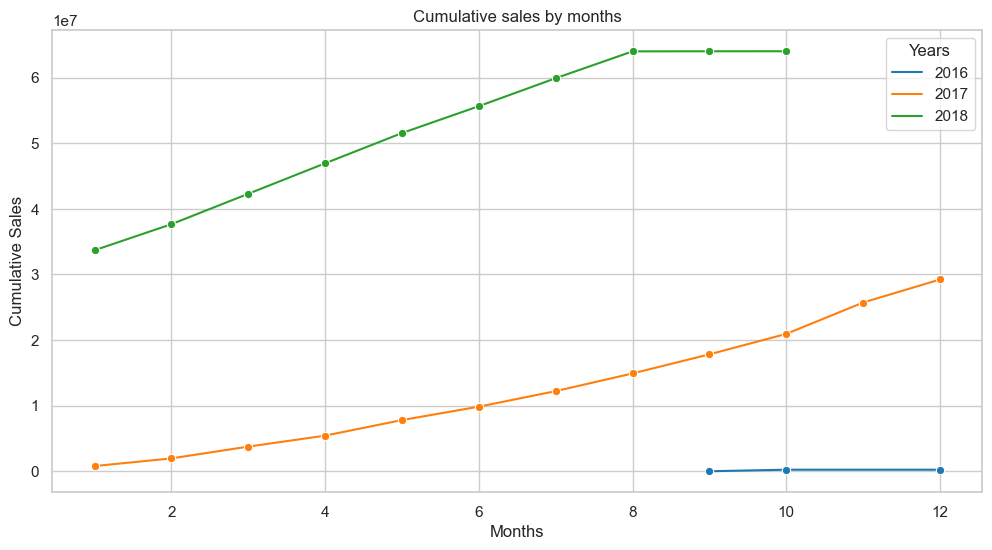

In [18]:
plt.figure(figsize = (12,6))
sns.set(style = 'whitegrid')
sns.lineplot(x = 'Months', y = 'Cumulative Sales', hue = 'Years', data = df, marker = "o", palette = "tab10", legend = "full")
plt.title("Cumulative sales by months")
plt.show()

# Calculate the year-over-year growth rate of total sales

In [19]:
query = """with year_sales as (select year(od.order_purchase_timestamp) as Years,
round(sum(p.payment_value),2) as Sales
from orders as od join payments as p
on od.order_id = p.order_id
group by Years
order by Years)

select years, Sales, lag(Sales, 1) over(order by Years) as previous_year_sales,
round((Sales - lag(Sales, 1) over(order by Years))/lag(Sales, 1) over(order by Years) * 100,2) as yoy_growth_Percent
from year_sales"""

cur.execute(query)
dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["Year","Sales","Previous year sale","yoy Growth %"])
df

,Year,Sales,Previous year sale,yoy Growth %
0,2016,237449.36,NaN,NaN
1,2017,28998986.91,237449.36,12112.7
2,2018,34799052.21,28998986.91,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [20]:
query = """with fo as (select customer_id, min(order_purchase_timestamp) as first_order
from orders
group by customer_id),
co as (select fo.customer_id, count(distinct(od.order_purchase_timestamp)) as count_of_order
from fo join orders as od
on fo.customer_id = od.customer_id
and od.order_purchase_timestamp > first_order
and od.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by fo.customer_id)

select (count(co.customer_id) / count(fo.customer_id))*100 as Retentaion_rate
from fo join co 
on fo.customer_id = co.customer_id"""

cur.execute(query)
dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["Retention_rate"])
df

# Since none of our customers buys again with us in 6 months so we have no Retention rate

,Retention_rate
0,None


# Top 3 customers who spent the most money in each year.

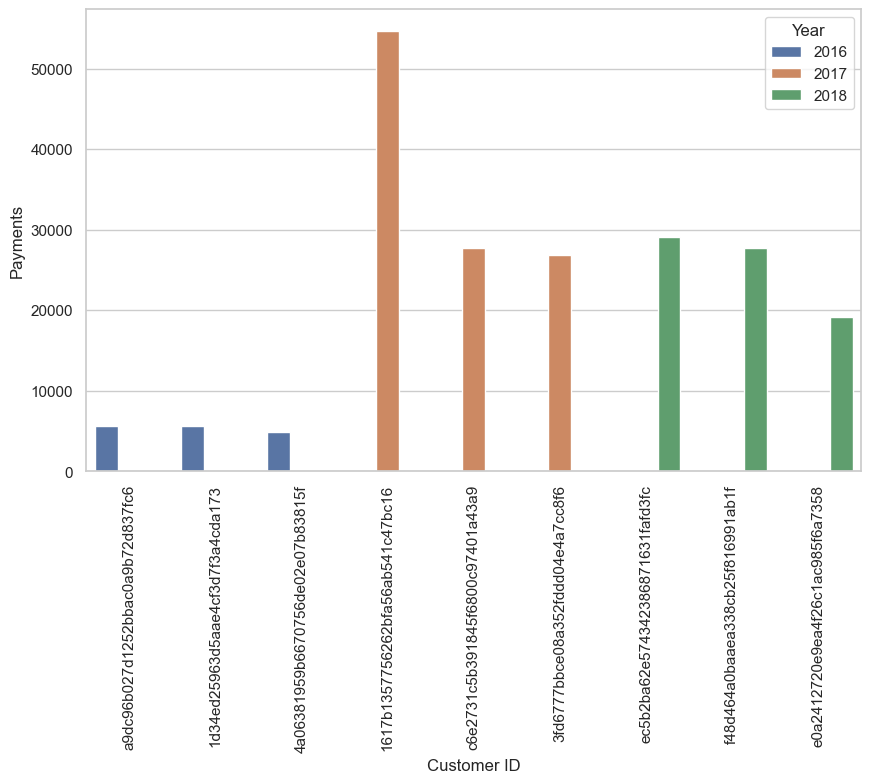

In [21]:
query = """select * from
(select year(od.order_purchase_timestamp) as Years, od.customer_id, sum(p.payment_value) as payment,
dense_rank() over(partition by year(od.order_purchase_timestamp) order by sum(p.payment_value) desc) as Rankk
from orders as od join payments as p
on od.order_id = p.order_id
group by year(od.order_purchase_timestamp), od.customer_id) as rn
where Rankk <= 3"""

cur.execute(query)
dt = cur.fetchall()
df = pd.DataFrame(dt, columns = ["Year","Customer ID","Payments","Rank"])
plt.figure(figsize = (10,6))
sns.barplot(x = "Customer ID", y = "Payments",hue = "Year",data = df )
plt.xticks(rotation = 90)
plt.show()